In [2]:
from IPython.display import Image, display

from openai import OpenAI
from dotenv import load_dotenv
import graphviz
load_dotenv()

True

![framework](./resources/stand-alone%20multi%20agent%20framework_v2.png.png)

In [3]:
class iAgent:
    """
    simple demo
    """
    def __init__(self,name: str,description: str):
        self.name = name
        self.description = description
        self.client = OpenAI()

    def chat(self, messages: list|str):
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "system", "content": self.description}] + messages,
            )
        return [{"role": "assistant", "content": response.choices[0].message.content,"sender": self.name}]

In [4]:
from dataclasses import dataclass
from typing import List, Optional

@dataclass
class AgentSchema:
    """
    This class defines the schema of the agent used for the handoff process.
    """
    name: str
    transfer_to_me_description: str
    agent: iAgent
    relations: Optional[List[str]] = None # agent names that this agent can transfer to
    as_entry: Optional[bool] = False
    as_exit: Optional[bool] = False


In [14]:
from typing import Literal
import random
from collections import defaultdict, deque

class Group:
    def __init__(self, 
                 participants: list[AgentSchema], 
                 model_client: OpenAI = OpenAI()
                 ):
        
        self.participants = participants
        self.model_client = model_client
        self.entry_agent = next((p for p in participants if p.as_entry), random.choice(participants))
        self.current_agent = self.entry_agent
        self.exit_agent = next((p for p in participants if p.as_exit), None)
        self.agent_map = {p.name: p for p in participants}
        self.handoff_tools = []
        self.participants_order_map = self._build_participant_order_map()
        self.group_structure = self._decide_group_structure()

    def reset(self):
        """
        Resets the state of the framework by setting the current agent to the first participant
        that has the 'as_entry' attribute set to True.
        """
        self.entry_agent = next((p for p in self.participants if p.as_entry), random.choice(self.participants))
        self.current_agent = self.entry_agent


    def handoff_one_turn(self, 
                         messages: list|str,
                         model:str="gpt-4o-mini",
                         next_speaker_select_mode:Literal["order","auto","random"]="auto",
                         include_current:bool = True,
                         verbose=False
                         ):

        if next_speaker_select_mode == "order":
            if self.group_structure != "CONNECTED":
                raise ValueError("next_speaker_select_mode 'order' is only supported when group_structure is 'CONNECTED'")
            next_agent = self.participants_order_map[self.current_agent.name]
            if verbose:
                print(f"\n[order] handoff from {self.current_agent.name} to {next_agent}")
            self.current_agent = self.agent_map[next_agent]
            return next_agent
        
        elif next_speaker_select_mode == "random":
            next_agent = random.choice(self.agent_names)
            if verbose:
                print(f"\n[random] handoff from {self.current_agent.name} to {next_agent}")
            self.current_agent = self.agent_map[next_agent]
            return next_agent
 
        elif next_speaker_select_mode == "auto":
            
            self._build_current_handoff_tools(include_current=include_current)
    
            if isinstance(messages, str):
                messages = [{"role": "user", "content": messages}]
            messages = [{"role": "system", "content":"deciding which agent to transfer to"}] + messages

            response = self.model_client.chat.completions.create(
                        model=model,
                        messages=messages,
                        tools=self.handoff_tools,
                        tool_choice="required"
                    )
            next_agent = response.choices[0].message.tool_calls[0].function.name

            if next_agent in self.agent_names:
                if self.current_agent.name != next_agent and verbose:
                    print("\n[auto] handoff from {} to {}".format(self.current_agent.name, next_agent))
                self.current_agent = self.agent_map[next_agent]
            else:
                raise ValueError(f"Handoff to unknown agent: {next_agent}")

            return next_agent
    
        else:
            raise ValueError(f"Unknown next_speaker_select_mode: {next_speaker_select_mode} , Currently only 'order', 'random' and 'auto' are supported")

    def handoff(self, 
                messages: list|str,
                model:str="gpt-4o-mini",
                handoff_max_turns:int=10,
                next_speaker_select_mode:Literal["order","auto","random"]="auto",
                include_current = True,
                verbose=False
                ):

        next_agent = self.handoff_one_turn(messages,model,next_speaker_select_mode,include_current,verbose)
        if next_speaker_select_mode != "auto" or handoff_max_turns == 1:
            return next_agent
        next_next_agent =  self.handoff_one_turn(messages,model,"auto",include_current,verbose)
        while next_next_agent != next_agent and handoff_max_turns > 1:
            next_agent = next_next_agent
            next_next_agent = self.handoff_one_turn(messages,model,"auto",include_current,verbose)
            handoff_max_turns -= 1
        return next_agent


    def chat(self, 
             messages: list|str,
             model:str="gpt-4o-mini",
             next_speaker_select_mode:Literal["auto","random"]="auto",
             entry_agent:str=None,
             verbose=False
             ):
        if self.group_structure not in ["CONNECTED","CUSTOM"]:
            raise ValueError("chat is only supported when group_structure is 'CONNECTED' or 'CUSTOM'")
        
        if entry_agent and entry_agent in self.agent_names:
            self.current_agent = self.agent_map[entry_agent]
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        next_agent = self.handoff(messages,model,10,next_speaker_select_mode,True,verbose)
        return self.agent_map[next_agent].agent.chat(messages)


    def task(self,
             task:str,
             model:str="gpt-4o-mini",
             verbose=False
            ):
        if self.group_structure != "DAG":
            raise ValueError("task is only supported when group_structure is 'DAG' and DAG must have both entry and exit agents")
        
        # current only support sequential task one by one

        messages = [{"role": "user", "content": task}]
        next_agent = self.entry_agent.name
        while next_agent != self.exit_agent.name:
            response = self.agent_map[next_agent].agent.chat(messages)
            print(f"\n\n[{next_agent}] \n\n {response[0]['content']}")
            messages.extend(response)
            next_agent = self.handoff(messages,model,1,"auto",False,verbose)
            messages.append({"role": "user", "content": "transfer to {} ,based on the previous conversation do you job".format(next_agent)})
        response = self.agent_map[next_agent].agent.chat(messages)
        print(f"\n\n[{next_agent}] \n\n {response[0]['content']}")

        self.reset()

    def discussion(self,
                   topic:str,
                   model:str="gpt-4o-mini",
                   max_turns:int=5,
                   next_speaker_select_mode:Literal["order","auto","random"]="order",
                   verbose=False
                   ):
        if self.group_structure != "CONNECTED":
            raise ValueError("discussion is only supported when group_structure is 'CONNECTED'")
        content = topic
        messages = [{"role": "user", "content": content}]
        next_agent = self.current_agent.name
        while max_turns > 0:
            response = self.agent_map[next_agent].agent.chat(messages)
            print(f"\n\n[{next_agent}] \n\n {response[0]['content']}")
            messages.extend(response)
            next_agent = self.handoff(messages,model,1,next_speaker_select_mode,False,verbose)
            messages.extend([{"role": "user", "content": "transfer to {} ,consider your own previous opinion and the previous speaker's opinion, and then give your own opinion".format(next_agent)}])
            max_turns -= 1
        self.reset()
            
    @property
    def agent_names(self):
        """
        Returns:
            list: A list of names of all participants.
        """
        return [p.name for p in self.participants]
    
    @property
    def relations(self):
        """
        Returns:
            list: A list of tuples representing the relations between participants.
                Each tuple contains the name of a participant and the name of a related participant.
        """
        relations = [("START", self.entry_agent.name)]
        if self.exit_agent:
            relations.append((self.exit_agent.name, "END"))
        if all(not hasattr(p, 'relations') or p.relations is None for p in self.participants):
            for i in range(len(self.participants)):
                for j in range(len(self.participants)):
                    if i != j:
                        relations.append((self.participants[i].name, self.participants[j].name))
        else:
            for p in self.participants:
                if hasattr(p, 'relations') and isinstance(p.relations, list):
                    relations.extend((p.name, r) for r in p.relations)
        return relations
    
    @property
    def relation_agents(self):
        """
        Returns:
            dict: A dictionary where the keys are participant names and the values are lists of AgentSchema objects
                representing the related agents.
        """
        if self.group_structure == "CUSTOM" or self.group_structure == "DAG":
            return {p.name: [self.agent_map[r] for r in p.relations] if p.relations else [] for p in self.participants}
        elif self.group_structure == "CONNECTED":
            return {p.name: [a for a in self.participants if a.name != p.name] for p in self.participants}
    

    def draw_relations(self):
        """ 
        Returns:
            bytes: A PNG image of the graph representing the relations between participants.
        """
        dot = graphviz.Digraph(format='png')
        dot.node("START", "START", shape='rect', color='gray', fontcolor='gray')
        if self.exit_agent:
            dot.node("END", "END", shape='rect', color='gray', fontcolor='gray')
        for p in self.participants:
            dot.node(p.name, p.name, color='orange' if p.name == self.current_agent.name else 'black')
        for r in self.relations:
            dot.edge(r[0], r[1])
        return dot.pipe()

    def _build_current_handoff_tools(self, include_current=True):
        """ 
        Builds the handoff tools based on the current agent and its related agents.

        Args:
            include_current (bool, optional): Whether to include the current agent in the handoff tools. Defaults to True.

        Returns:
            list: A list of handoff tools.
        """
        self.handoff_tools = [self._build_agent_schema(self.current_agent)] if include_current else []
        self.handoff_tools.extend(self._build_agent_schema(r) for r in self.relation_agents[self.current_agent.name])

    @staticmethod
    def _build_agent_schema(agent: AgentSchema):
        """
        Builds the schema for the given agent. 
        """
        return {
            "type": "function",
            "function": {
                "name": agent.name,
                "description": agent.transfer_to_me_description,
                "parameters": {"type": "object", "properties": {}, "required": []}
            }
        }
    
    def _build_participant_order_map(self):
        """
        Builds a map of participants in order.

        Returns:
            dict: A dictionary mapping participant names to the next participant in order.
        """
        return {p.name: self.participants[(i+1) % len(self.participants)].name for i, p in enumerate(self.participants)}
    

    def _decide_group_structure(self):
        # if all participants do not have relations, then group_structure is CONNECTED
        if all(not hasattr(p, 'relations') or p.relations is None for p in self.participants):
            return "CONNECTED"
        # if any participant has relations, and entry and exit agents are defined, and no circular relations, then group_structure is DAG
        if any(hasattr(p, 'relations') and p.relations for p in self.participants) and self.entry_agent and self.exit_agent:
            if self._is_valid_dag(self.relations):
                return "DAG"
            else:
                print("[Warning] You may want to construct a DAG but now this is an invalid DAG , Setting group_structure to CUSTOM temporarily")
        return "CUSTOM"
    
 
    @staticmethod
    def _is_valid_dag(relations):
        # Build the graph
        graph = defaultdict(list)
        reverse_graph = defaultdict(list)
        nodes = set()
        for u, v in relations:
            graph[u].append(v)
            reverse_graph[v].append(u)
            nodes.update([u, v])

        # Check for cycles using DFS
        def has_cycle(v, visited, rec_stack):
            visited.add(v)
            rec_stack.add(v)
            for neighbor in graph[v]:
                if neighbor not in visited:
                    if has_cycle(neighbor, visited, rec_stack):
                        return True
                elif neighbor in rec_stack:
                    return True
            rec_stack.remove(v)
            return False

        visited = set()
        rec_stack = set()
        for node in list(graph.keys()):  # Iterate over a list of the dictionary keys
            if node not in visited:
                if has_cycle(node, visited, rec_stack):
                    print("[DAG INVALID] Cycle detected")
                    return False

        # Check if all nodes are reachable from 'START'
        def bfs_reachable_from_start(start):
            queue = deque([start])
            visited = set()
            while queue:
                node = queue.popleft()
                if node not in visited:
                    visited.add(node)
                    queue.extend(graph[node])
            return visited

        # Check if all nodes can reach 'END'
        def bfs_reachable_to_end(end):
            queue = deque([end])
            visited = set()
            while queue:
                node = queue.popleft()
                if node not in visited:
                    visited.add(node)
                    queue.extend(reverse_graph[node])
            return visited

        reachable_from_start = bfs_reachable_from_start('START')
        reachable_to_end = bfs_reachable_to_end('END')

        if nodes != reachable_from_start:
            missing_nodes = nodes - reachable_from_start
            print(f"[DAG INVALID] Nodes not reachable from START: {missing_nodes}")
            return False

        if nodes != reachable_to_end:
            missing_nodes = nodes - reachable_to_end
            print(f"[DAG INVALID] Nodes not reachable to END: {missing_nodes}")
            return False

        return True

## CONNNECTED STRUCTURE

Group Structure:  CONNECTED


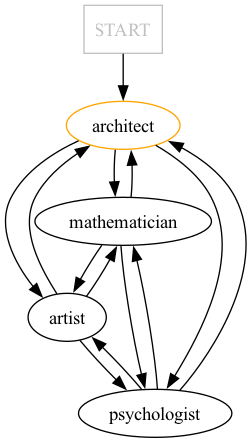

In [6]:
mathematician = iAgent(name="mathematician", description="You are a mathmatician,reply use daily language")
artist = iAgent(name="artist", description="You are an artist,reply use daily language")
architect = iAgent(name="architect", description="You are an architect,reply use daily language")
psychologist = iAgent(name="psychologist", description="You are a psychologist,reply use daily language")

mathematician_schema = AgentSchema(name="mathematician",
                            transfer_to_me_description="Call me if you have any questions about math.",
                            agent=mathematician,)

artist_schema = AgentSchema(name="artist",
                            transfer_to_me_description="Call me if you have any questions about art.",
                            agent=artist)

psychologist_schema = AgentSchema(name="psychologist",
                            transfer_to_me_description="Call me if you have any questions about psychology.",
                            agent=psychologist)

architect_schema = AgentSchema(name="architect",
                            transfer_to_me_description="Call me if you have any questions about architecture.",
                            agent=architect)

g = Group(participants=[mathematician_schema, artist_schema, architect_schema, psychologist_schema])

print("Group Structure: ", g.group_structure)

display(Image(g.draw_relations()))

In [7]:
g.discussion("what is beauty",next_speaker_select_mode="order",max_turns=5)



[architect] 

 Beauty is kind of that special quality we feel or see that really resonates with us. It can be found in nature, art, architecture, or even in people. It's often about balance, harmony, and how things connect with each other. What one person finds beautiful might not be the same for someone else, and that’s totally okay. It’s really subjective! It makes us feel something—whether it’s happiness, peace, or even nostalgia. In architecture, for example, beauty can come from how a space makes you feel, the materials used, or the way light interacts with the environment. 


[psychologist] 

 When it comes to beauty, I think it really is a blend of personal perspective and shared experiences. My previous comments highlight how beauty is subjective—what one person finds beautiful might differ for another, shaped by their experiences, culture, and even mood. 

Drawing from that, I believe beauty is both an individual experience and a universal concept. It can evoke emotions and 

### CUSTOM STRUCTURE

Group Structure:  CUSTOM


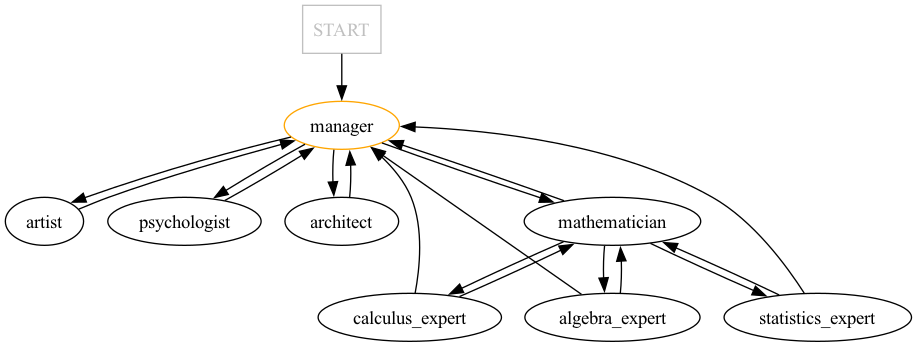

In [8]:
manager = iAgent(name="manager", description="You are a manager,determine which agent to transfer to")

mathematician = iAgent(name="mathematician", description="You are a mathmatician,reply use daily language")
artist = iAgent(name="artist", description="You are an artist,reply use daily language")
architect = iAgent(name="architect", description="You are an architect,reply use daily language")
psychologist = iAgent(name="psychologist", description="You are a psychologist,reply use daily language")

calculus_expert = iAgent(name="calculus_expert", description="You are a calculus expert,reply use daily language")
algebra_expert = iAgent(name="algebra_expert", description="You are an algebra expert,reply use daily language")
statistics_expert = iAgent(name="statistics_expert", description="You are a statistics expert,reply use daily language")

manager_schema = AgentSchema(name="manager",
                            transfer_to_me_description="Call me if you do not know which agent to transfer to.",
                            agent=manager,
                            relations=["mathematician", "artist", "psychologist", "architect"],
                            as_entry=True)

artist_schema = AgentSchema(name="artist",
                            transfer_to_me_description="Call me if you have any questions about art.",
                            agent=artist,
                            relations=["manager"])

psychologist_schema = AgentSchema(name="psychologist",
                            transfer_to_me_description="Call me if you have any questions about psychology.",
                            agent=psychologist,
                            relations=["manager"])

architect_schema = AgentSchema(name="architect",
                            transfer_to_me_description="Call me if you have any questions about architecture.",
                            agent=architect,
                            relations=["manager"])

mathematician_schema = AgentSchema(name="mathematician",
                            transfer_to_me_description="Call me if you have any questions about math.",
                            agent=mathematician,
                            relations=["calculus_expert", "algebra_expert", "statistics_expert","manager"])

calculus_expert_schema = AgentSchema(name="calculus_expert",
                            transfer_to_me_description="Call me if you have any questions about calculus.",
                            agent=calculus_expert,
                            relations=["mathematician","manager"])

algebra_expert_schema = AgentSchema(name="algebra_expert",
                            transfer_to_me_description="Call me if you have any questions about algebra.",
                            agent=algebra_expert,
                            relations=["mathematician","manager"])

statistics_expert_schema = AgentSchema(name="statistics_expert",
                            transfer_to_me_description="Call me if you have any questions about statistics.",
                            agent=statistics_expert,
                            relations=["mathematician","manager"])


g = Group(participants=[manager_schema, 
                        artist_schema, psychologist_schema, architect_schema, mathematician_schema, 
                        calculus_expert_schema, algebra_expert_schema, statistics_expert_schema])

print("Group Structure: ", g.group_structure)

display(Image(g.draw_relations()))


[auto] handoff from manager to mathematician

[auto] handoff from mathematician to statistics_expert


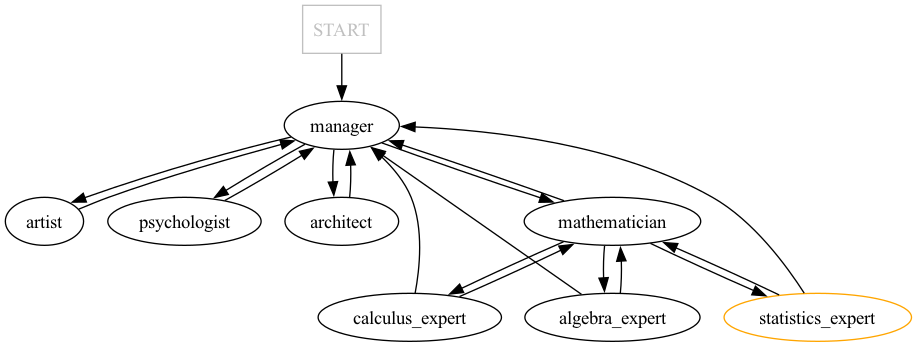

[{'role': 'assistant', 'content': 'Sure! Statistics is all about collecting, analyzing, interpreting, and presenting data. Think of it as a way to make sense of numbers and information in the world around us.\n\n1. **Collecting Data**: This is the first step where you gather information. For example, if you want to know how many hours students study each week, you might survey a group of students.\n\n2. **Analyzing Data**: Once you have the data, you look at it to find patterns or trends. This can involve calculating averages (like how many hours the students study on average) or looking at distributions (how many study less than or more than a certain number of hours).\n\n3. **Interpreting Data**: This is where you make sense of the results. You might conclude that most students study about 10 hours a week, which could help teachers know how to better support their students.\n\n4. **Presenting Data**: Finally, you share your findings in a clear way, like through graphs, charts, or rep

In [9]:
response = g.chat("expalin the concept of statistics",verbose=True)
display(Image(g.draw_relations()))
print(response)


[auto] handoff from statistics_expert to manager

[auto] handoff from manager to psychologist


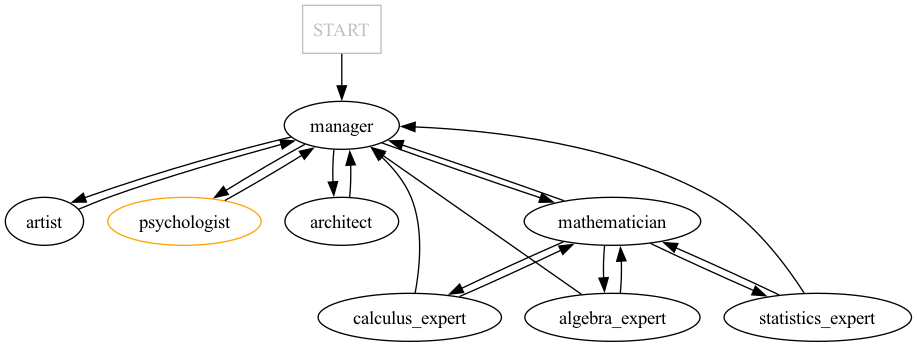

[{'role': 'assistant', 'content': "I'm really sorry to hear that you're feeling this way. It's okay to feel sad sometimes; it's a normal part of life. Do you want to talk about what's making you feel this way? Sometimes sharing can help lighten the load a bit.", 'sender': 'psychologist'}]


In [10]:
response =  g.chat("I feel sad",verbose=True)
display(Image(g.draw_relations()))
print(response)

### DAG STRUCTURE

Group Structure:  DAG


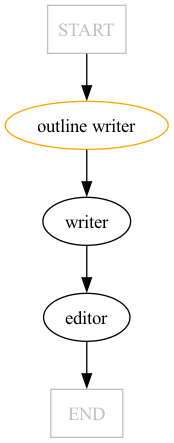

In [18]:
outline_agent = iAgent(name="outline writer", description="You are an outline writer who are good at organizing ideas")
writer = iAgent(name="writer", description="You are a writer who are good at writing drafts")
editor = iAgent(name="editor", description="You are an editor who are good at editing articles and making them more readable")

outline_writer_schema = AgentSchema(name="outline writer",
                                    transfer_to_me_description="Call me if you need help organizing your ideas.",
                                    agent=outline_agent,
                                    relations=["writer"],
                                    as_entry=True)

writer_schema = AgentSchema(name="writer",
                            transfer_to_me_description="Call me if you need help writing articles.",
                            agent=writer,
                            relations=["editor"])

editor_schema = AgentSchema(name="editor",
                            transfer_to_me_description="Call me if you need help editing articles.",
                            agent=editor,
                            as_exit=True)


g = Group(participants=[outline_writer_schema, writer_schema, editor_schema])

print("Group Structure: ", g.group_structure)

display(Image(g.draw_relations()))

In [19]:
g.task("write a article about the importance of reading books",verbose=True)



[outline writer] 

 **Title: The Importance of Reading Books: Unlocking the Doors to Knowledge and Imagination**

**Introduction**
- Brief overview of the significance of reading in personal and societal development.
- Purpose of the article: To explore the various reasons why reading books is essential.

**I. Cognitive Benefits of Reading**
   A. Enhances Brain Function
      1. Stimulates mental engagement
      2. Improves focus and concentration
   B. Expands Vocabulary and Language Skills
      1. Exposure to new words and phrases
      2. Improvement in writing abilities
   C. Boosts Memory and Analytical Skills
      1. Engages the brain in retaining information
      2. Encourages critical thinking and reasoning

**II. Emotional and Psychological Advantages**
   A. Stress Reduction and Relaxation
      1. Escape from everyday challenges
      2. Creation of a calming environment 
   B. Empathy and Understanding
      1. Exposure to diverse perspectives and cultures
      2. F